# **Objaverse Length Unit Distribution**

This notebook downloads a sample of 100 assets from Objaverse and see what percentage of them are in units other than meters, by checking for abnormally small or large bounding box sizes.

In [1]:
import json
import multiprocessing
from pathlib import Path
from typing import Dict, Optional
from urllib.parse import urlparse
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyvista as pv
import open3d as o3d
import objaverse
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def extract_uid_from_url(url: str) -> str:
    """
    Extract the UID from an Objaverse URL.

    Args:
        url: Objaverse URL containing the UID

    Returns:
        The UID string (filename without .glb extension)
    """
    parsed_url = urlparse(url)
    filename = Path(parsed_url.path).name
    return filename.replace(".glb", "")


def download_assets_with_objaverse(asset_urls: list[str]) -> Dict[str, str]:
    """
    Download assets using the objaverse library.

    Args:
        asset_urls: List of Objaverse URLs

    Returns:
        Dictionary mapping UIDs to local file paths
    """
    # Extract UIDs from URLs
    asset_ids = [extract_uid_from_url(url) for url in asset_urls]

    logger.info(f"Downloading {len(asset_ids)} assets using objaverse...")

    # Use objaverse to download assets
    processes = multiprocessing.cpu_count()
    asset_paths = objaverse.load_objects(
        uids=asset_ids, download_processes=max(1, int(processes / 2))
    )

    logger.info(f"Successfully downloaded {len(asset_paths)} assets")
    return asset_paths

In [3]:
def analyze_glb_bounding_box_pyvista(file_path: str) -> Optional[Dict]:
    """
    Analyze a GLB file using PyVista and extract bounding box information.

    Args:
        file_path: Path to the GLB file

    Returns:
        Dictionary with bounding box analysis or None if failed
    """
    try:
        # Load the mesh using PyVista
        mesh = pv.read(file_path)

        # Get bounds: [xmin, xmax, ymin, ymax, zmin, zmax]
        bounds = mesh.bounds

        # Calculate dimensions
        width = bounds[1] - bounds[0]  # x dimension
        height = bounds[3] - bounds[2]  # y dimension
        depth = bounds[5] - bounds[4]  # z dimension

        dimensions = np.array([width, height, depth])

        # Calculate various metrics
        longest_edge = np.max(dimensions)
        shortest_edge = np.min(dimensions)
        diagonal = np.linalg.norm(dimensions)
        volume = width * height * depth

        return {
            "width": width,
            "height": height,
            "depth": depth,
            "longest_edge": longest_edge,
            "shortest_edge": shortest_edge,
            "diagonal": diagonal,
            "volume": volume,
            "dimensions": dimensions.tolist(),
            "bounds": bounds,
            "backend": "pyvista",
        }

    except Exception as e:
        logger.error(f"Failed to analyze {file_path} with PyVista: {str(e)}")
        return None


def analyze_glb_bounding_box_open3d(file_path: str) -> Optional[Dict]:
    """
    Analyze a GLB file using Open3D and extract bounding box information.

    Args:
        file_path: Path to the GLB file

    Returns:
        Dictionary with bounding box analysis or None if failed
    """
    try:
        # Load the mesh using Open3D
        mesh = o3d.io.read_triangle_mesh(file_path)

        if len(mesh.vertices) == 0:
            logger.warning(f"No vertices found in {file_path}")
            return None

        # Get the axis-aligned bounding box
        bbox = mesh.get_axis_aligned_bounding_box()

        # Get min and max points
        min_bound = bbox.get_min_bound()
        max_bound = bbox.get_max_bound()

        # Calculate dimensions
        width = max_bound[0] - min_bound[0]  # x dimension
        height = max_bound[1] - min_bound[1]  # y dimension
        depth = max_bound[2] - min_bound[2]  # z dimension

        dimensions = np.array([width, height, depth])

        # Calculate various metrics
        longest_edge = np.max(dimensions)
        shortest_edge = np.min(dimensions)
        diagonal = np.linalg.norm(dimensions)
        volume = width * height * depth

        # Create bounds array in PyVista format for consistency
        bounds = [
            min_bound[0],
            max_bound[0],
            min_bound[1],
            max_bound[1],
            min_bound[2],
            max_bound[2],
        ]

        return {
            "width": width,
            "height": height,
            "depth": depth,
            "longest_edge": longest_edge,
            "shortest_edge": shortest_edge,
            "diagonal": diagonal,
            "volume": volume,
            "dimensions": dimensions.tolist(),
            "bounds": bounds,
            "backend": "open3d",
        }

    except Exception as e:
        logger.error(f"Failed to analyze {file_path} with Open3D: {str(e)}")
        return None


def analyze_glb_bounding_box(
    file_path: str, backend: str = "pyvista"
) -> Optional[Dict]:
    """
    Analyze a GLB file and extract bounding box information using specified backend.

    Args:
        file_path: Path to the GLB file
        backend: Analysis backend ('pyvista' or 'open3d')

    Returns:
        Dictionary with bounding box analysis or None if failed
    """
    if backend.lower() == "open3d":
        return analyze_glb_bounding_box_open3d(file_path)
    elif backend.lower() == "pyvista":
        return analyze_glb_bounding_box_pyvista(file_path)
    else:
        logger.error(f"Unknown backend: {backend}. Using PyVista as fallback.")
        return analyze_glb_bounding_box_pyvista(file_path)

In [4]:
def classify_unit_scale(longest_edge: float) -> str:
    """
    Classify the likely unit scale based on the longest edge of the bounding box.

    Assumptions:
    - Most real-world objects should be between 0.01m (1cm) and 100m in their longest dimension
    - Objects much smaller might be in millimeters
    - Objects much larger might be in different units or incorrectly scaled

    Args:
        longest_edge: Longest edge dimension

    Returns:
        Predicted unit scale category
    """
    if longest_edge < 0.001:  # Less than 1mm
        return "Micro/Invalid"
    elif longest_edge < 0.01:  # 1mm to 1cm - likely millimeters
        return "Likely Millimeters"
    elif longest_edge <= 100:  # 1cm to 100m - reasonable meter scale
        return "Likely Meters"
    elif longest_edge <= 1000:  # 100m to 1km - possibly oversized
        return "Likely Oversized"
    else:  # > 1km
        return "Extremely Large/Invalid"

In [5]:
# Configuration
# ANALYSIS_BACKEND = 'pyvista'  # Options: 'pyvista', 'open3d'
ANALYSIS_BACKEND = "open3d"  # Options: 'pyvista', 'open3d'

# Load asset URLs
with open("objaverse_asset_sample.json", "r") as f:
    asset_urls = json.load(f)

print(f"Loaded {len(asset_urls)} asset URLs")
print(f"Using analysis backend: {ANALYSIS_BACKEND}")

Loaded 100 asset URLs
Using analysis backend: open3d


In [6]:
# Download all assets using objaverse
logger.info("Starting batch download of all assets...")
asset_paths = download_assets_with_objaverse(asset_urls)

# Analyze downloaded assets
results = []
failed_downloads = len(asset_urls) - len(asset_paths)
failed_analyses = 0

# Create URL to UID mapping for metadata
url_to_uid = {url: extract_uid_from_url(url) for url in asset_urls}
uid_to_url = {uid: url for url, uid in url_to_uid.items()}

# Create a progress bar for analysis
for uid, local_path in tqdm(
    asset_paths.items(), desc=f"Analyzing assets with {ANALYSIS_BACKEND}"
):
    # Analyze the file using the specified backend
    analysis = analyze_glb_bounding_box(local_path, backend=ANALYSIS_BACKEND)

    if analysis is None:
        failed_analyses += 1
        continue

    # Add metadata
    original_url = uid_to_url.get(uid, "")
    analysis["url"] = original_url
    analysis["filename"] = Path(original_url).name if original_url else f"{uid}.glb"
    analysis["uid"] = uid
    analysis["unit_classification"] = classify_unit_scale(analysis["longest_edge"])

    results.append(analysis)

print("\nProcessing complete!")
print(f"Successfully analyzed: {len(results)} assets")
print(f"Failed downloads: {failed_downloads}")
print(f"Failed analyses: {failed_analyses}")

INFO:__main__:Starting batch download of all assets...
INFO:__main__:Downloading 100 assets using objaverse...
INFO:__main__:Successfully downloaded 100 assets
Analyzing assets with open3d:   6%|▌         | 6/100 [00:00<00:08, 11.07it/s]WARNING:__main__:No vertices found in /home/ycho358/.objaverse/hf-objaverse-v1/glbs/000-023/a7ad32b5d4d84ee5a40ebbd86da4dbe4.glb


[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1


Analyzing assets with open3d:  25%|██▌       | 25/100 [00:04<00:09,  7.94it/s]

[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2


Analyzing assets with open3d:  60%|██████    | 60/100 [00:07<00:03, 10.98it/s]

[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2


Analyzing assets with open3d:  76%|███████▌  | 76/100 [00:09<00:01, 12.34it/s]

[Open3D INFO] Skipping non-triangle primitive geometry of type: 1


Analyzing assets with open3d:  81%|████████  | 81/100 [00:10<00:03,  6.07it/s]

[Open3D INFO] Skipping non-triangle primitive geometry of type: 1


Analyzing assets with open3d:  83%|████████▎ | 83/100 [00:10<00:02,  6.39it/s]

[Open3D INFO] Skipping non-triangle primitive geometry of type: 1


Analyzing assets with open3d:  88%|████████▊ | 88/100 [00:11<00:01,  7.61it/s]

[Open3D INFO] Skipping non-triangle primitive geometry of type: 2


Analyzing assets with open3d: 100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Processing complete!
Successfully analyzed: 96 assets
Failed downloads: 0
Failed analyses: 4


In [7]:
# Create DataFrame for easier analysis
df = pd.DataFrame(results)

if len(df) > 0:
    print("\nDataset Summary:")
    print(
        f"Analysis backend used: {df['backend'].iloc[0] if 'backend' in df.columns else ANALYSIS_BACKEND}"
    )
    print(f"Total successfully analyzed assets: {len(df)}")
    print(
        f"Longest edge range: {df['longest_edge'].min():.6f} to {df['longest_edge'].max():.2f}"
    )
    print(f"Volume range: {df['volume'].min():.10f} to {df['volume'].max():.2f}")
    print("\nUnit Classification Distribution:")
    print(df["unit_classification"].value_counts())


Dataset Summary:
Analysis backend used: open3d
Total successfully analyzed assets: 96
Longest edge range: 0.021235 to 28909.27
Volume range: 0.0000024607 to 5480142198825.84

Unit Classification Distribution:
unit_classification
Likely Meters              67
Likely Oversized           16
Extremely Large/Invalid    13
Name: count, dtype: int64


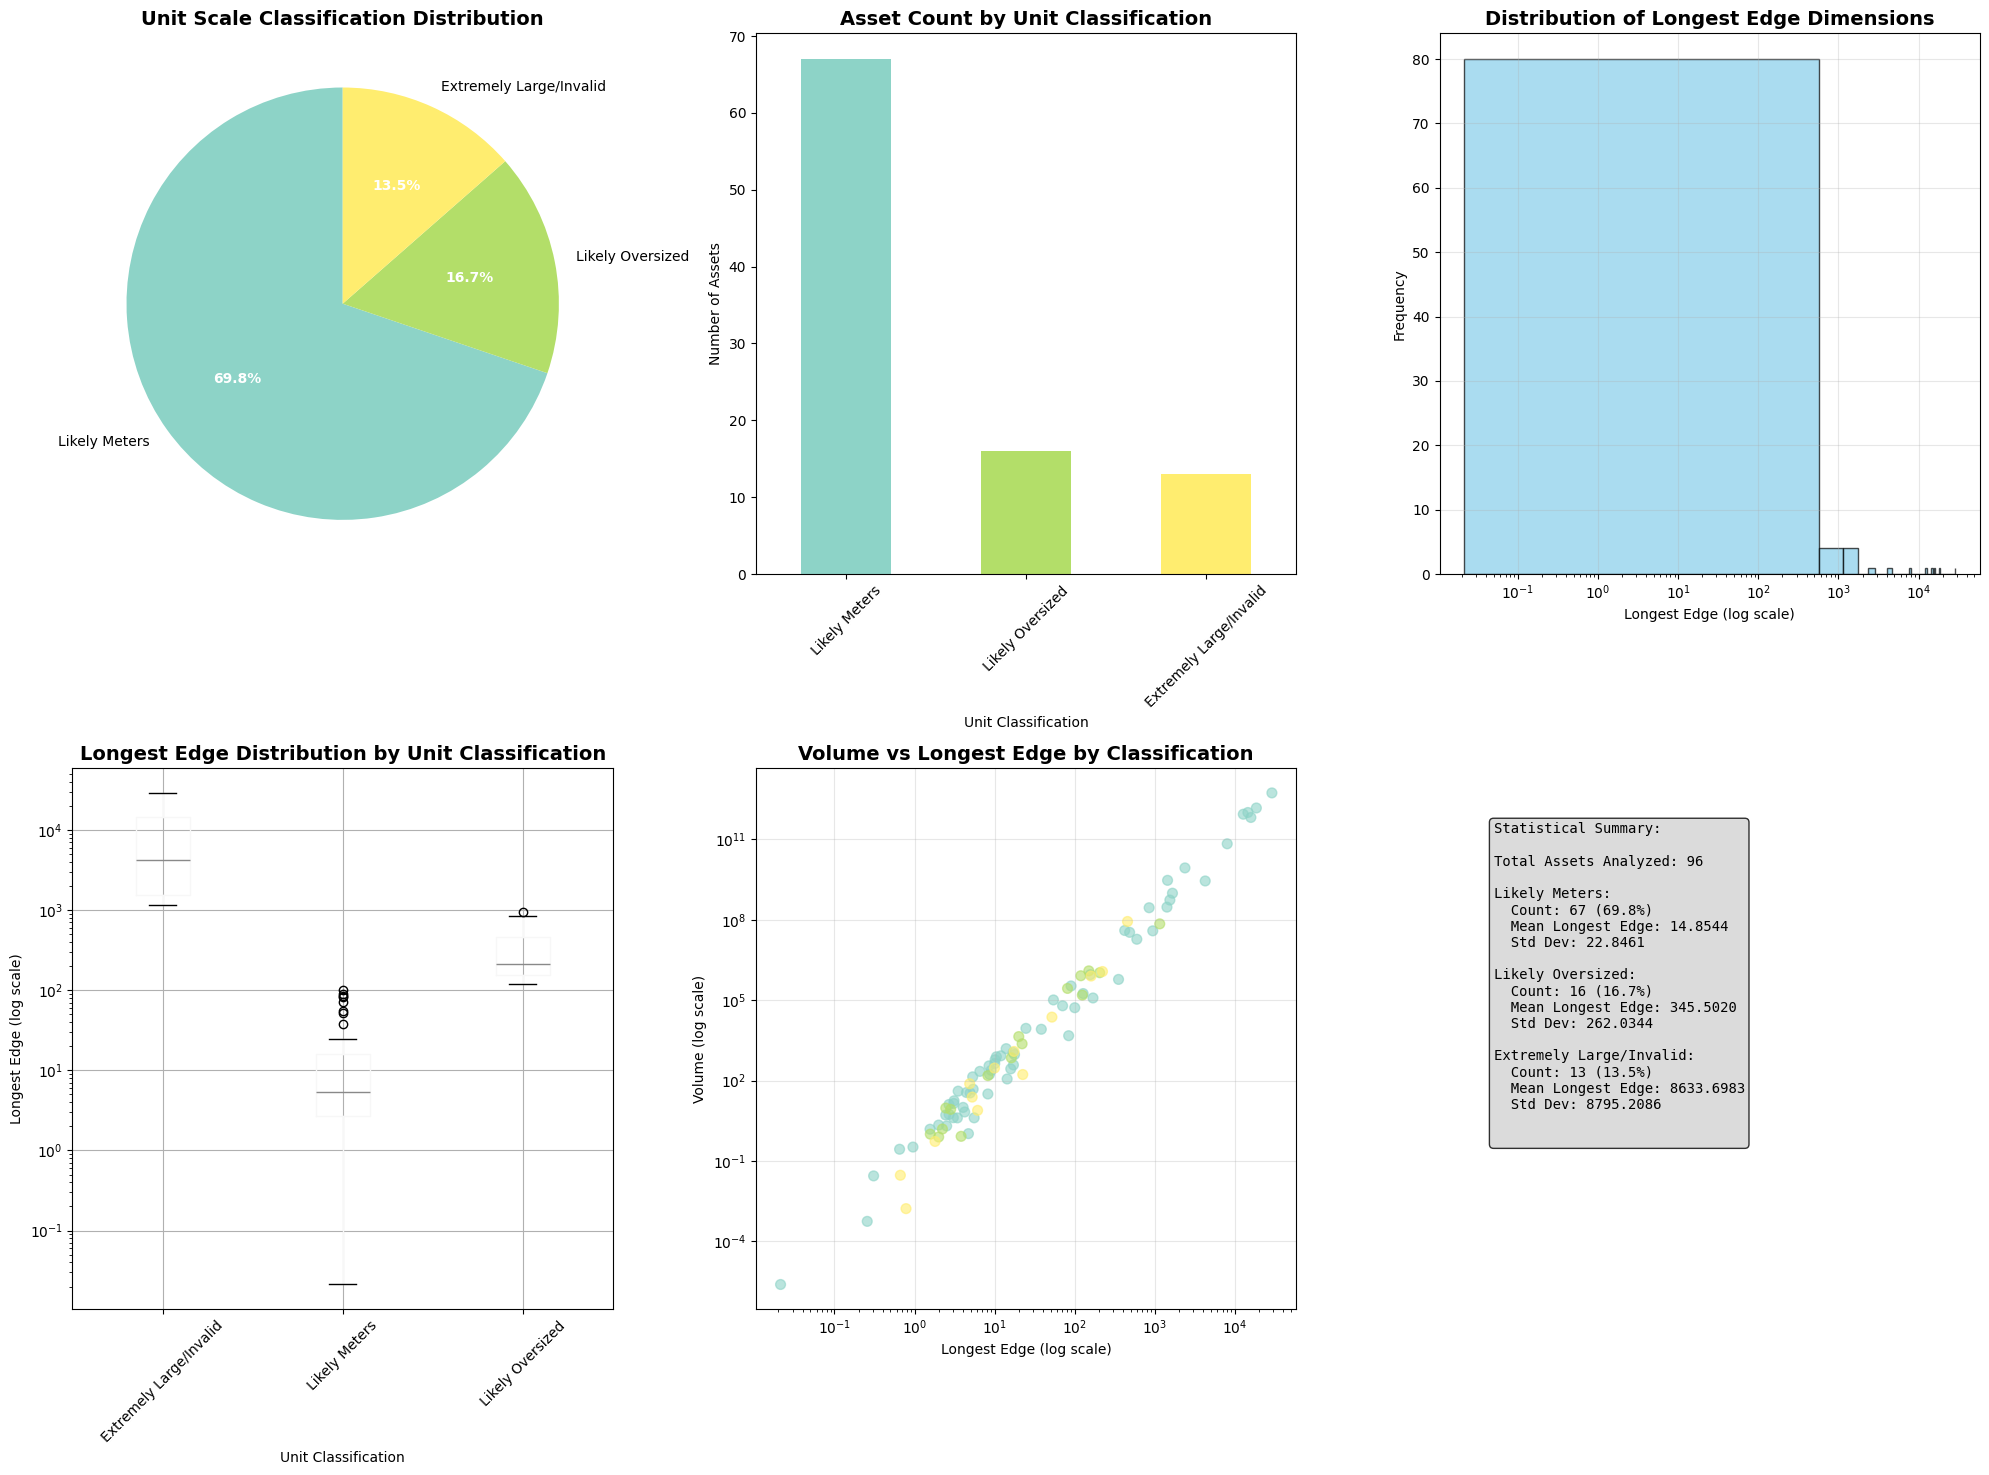

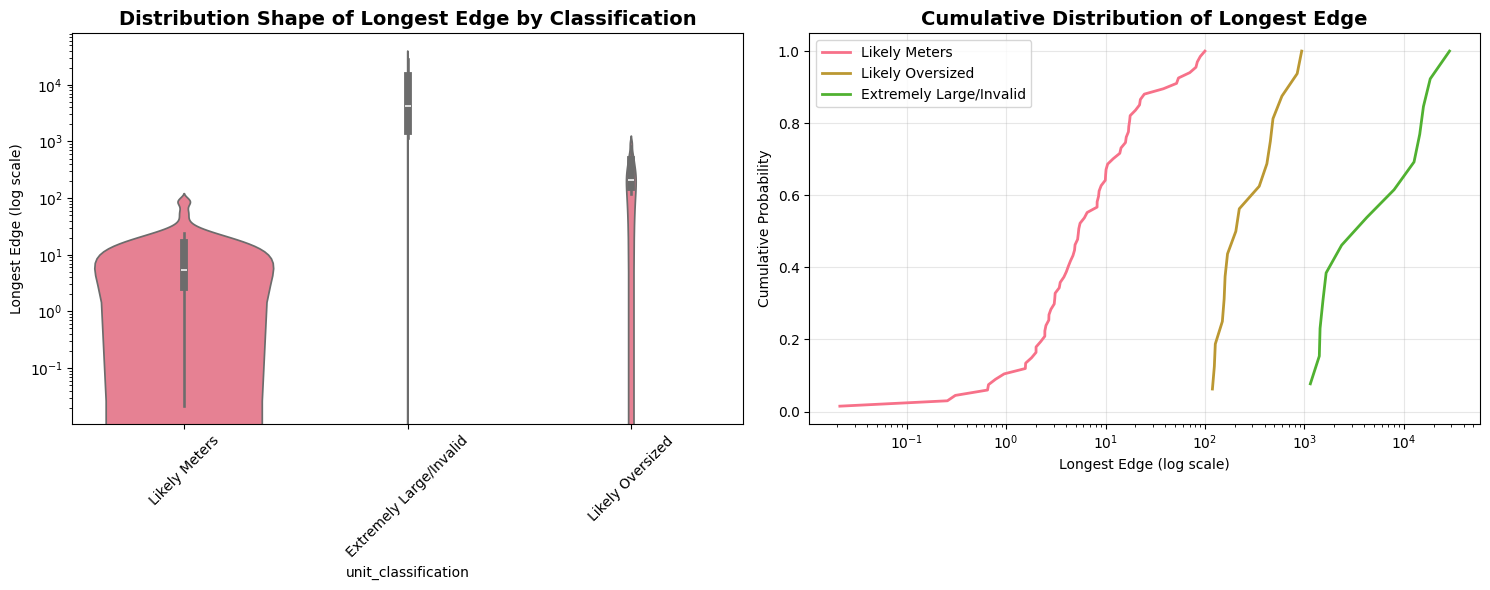

In [8]:
# Create comprehensive visualizations
if len(df) > 0:
    # Set up the plotting style
    plt.style.use("default")
    sns.set_palette("husl")

    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))

    # 1. Pie Chart - Unit Classification Distribution
    ax1 = plt.subplot(2, 3, 1)
    unit_counts = df["unit_classification"].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(unit_counts)))
    wedges, texts, autotexts = ax1.pie(
        unit_counts.values,
        labels=unit_counts.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=colors,
    )
    ax1.set_title(
        "Unit Scale Classification Distribution", fontsize=14, fontweight="bold"
    )

    # Make percentage text more readable
    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontweight("bold")

    # 2. Bar Chart - Unit Classification Counts
    ax2 = plt.subplot(2, 3, 2)
    unit_counts.plot(kind="bar", ax=ax2, color=colors)
    ax2.set_title("Asset Count by Unit Classification", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Unit Classification")
    ax2.set_ylabel("Number of Assets")
    ax2.tick_params(axis="x", rotation=45)

    # 3. Histogram - Longest Edge Distribution (Log Scale)
    ax3 = plt.subplot(2, 3, 3)
    ax3.hist(df["longest_edge"], bins=50, alpha=0.7, color="skyblue", edgecolor="black")
    ax3.set_xlabel("Longest Edge (log scale)")
    ax3.set_ylabel("Frequency")
    ax3.set_title(
        "Distribution of Longest Edge Dimensions", fontsize=14, fontweight="bold"
    )
    ax3.set_xscale("log")
    ax3.grid(True, alpha=0.3)

    # 4. Box Plot - Longest Edge by Classification
    ax4 = plt.subplot(2, 3, 4)
    df.boxplot(column="longest_edge", by="unit_classification", ax=ax4)
    ax4.set_title(
        "Longest Edge Distribution by Unit Classification",
        fontsize=14,
        fontweight="bold",
    )
    ax4.set_xlabel("Unit Classification")
    ax4.set_ylabel("Longest Edge (log scale)")
    ax4.set_yscale("log")
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
    plt.suptitle("")  # Remove automatic title

    # 5. Scatter Plot - Volume vs Longest Edge
    ax5 = plt.subplot(2, 3, 5)
    scatter = ax5.scatter(
        df["longest_edge"],
        df["volume"],
        c=[
            colors[i]
            for i in range(len(unit_counts))
            for _ in range(unit_counts.iloc[i])
        ],
        alpha=0.6,
        s=50,
    )
    ax5.set_xlabel("Longest Edge (log scale)")
    ax5.set_ylabel("Volume (log scale)")
    ax5.set_title(
        "Volume vs Longest Edge by Classification", fontsize=14, fontweight="bold"
    )
    ax5.set_xscale("log")
    ax5.set_yscale("log")
    ax5.grid(True, alpha=0.3)

    # 6. Detailed Statistics Table (as text)
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis("off")

    # Create statistics summary
    stats_text = "Statistical Summary:\n\n"
    stats_text += f"Total Assets Analyzed: {len(df)}\n\n"

    for unit_type in unit_counts.index:
        subset = df[df["unit_classification"] == unit_type]
        count = len(subset)
        percentage = (count / len(df)) * 100
        mean_edge = subset["longest_edge"].mean()
        std_edge = subset["longest_edge"].std()

        stats_text += f"{unit_type}:\n"
        stats_text += f"  Count: {count} ({percentage:.1f}%)\n"
        stats_text += f"  Mean Longest Edge: {mean_edge:.4f}\n"
        stats_text += f"  Std Dev: {std_edge:.4f}\n\n"

    ax6.text(
        0.1,
        0.9,
        stats_text,
        transform=ax6.transAxes,
        fontsize=10,
        verticalalignment="top",
        fontfamily="monospace",
        bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.8),
    )

    # Adjust layout and save
    plt.tight_layout()
    backend_name = (
        df["backend"].iloc[0] if "backend" in df.columns else ANALYSIS_BACKEND
    )
    plt.savefig(
        f"objaverse_length_unit_analysis_{backend_name}.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Create an additional detailed distribution plot
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Violin plot for better distribution visualization
    sns.violinplot(data=df, x="unit_classification", y="longest_edge", ax=ax1)
    ax1.set_yscale("log")
    ax1.set_title(
        "Distribution Shape of Longest Edge by Classification",
        fontsize=14,
        fontweight="bold",
    )
    ax1.tick_params(axis="x", rotation=45)
    ax1.set_ylabel("Longest Edge (log scale)")

    # Cumulative distribution
    for unit_type in unit_counts.index:
        subset = df[df["unit_classification"] == unit_type][
            "longest_edge"
        ].sort_values()
        y_vals = np.arange(1, len(subset) + 1) / len(subset)
        ax2.plot(subset, y_vals, label=unit_type, linewidth=2)

    ax2.set_xscale("log")
    ax2.set_xlabel("Longest Edge (log scale)")
    ax2.set_ylabel("Cumulative Probability")
    ax2.set_title(
        "Cumulative Distribution of Longest Edge", fontsize=14, fontweight="bold"
    )
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        f"objaverse_detailed_distributions_{backend_name}.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

else:
    print("No data to visualize - all downloads/analyses failed!")

In [9]:
# Export results to CSV for further analysis
if len(df) > 0:
    backend_name = (
        df["backend"].iloc[0] if "backend" in df.columns else ANALYSIS_BACKEND
    )
    csv_filename = f"objaverse_bounding_box_analysis_{backend_name}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Results exported to '{csv_filename}'")

    # Print some interesting findings
    print("\n" + "=" * 60)
    print("ANALYSIS FINDINGS")
    print("=" * 60)

    meter_scale = df[df["unit_classification"] == "Likely Meters"]
    mm_scale = df[df["unit_classification"] == "Likely Millimeters"]
    oversized = df[df["unit_classification"] == "Likely Oversized"]

    total_reasonable = len(meter_scale)
    total_problematic = len(mm_scale) + len(oversized)

    print(
        f"Assets likely in proper meter scale: {total_reasonable} ({total_reasonable / len(df) * 100:.1f}%)"
    )
    print(
        f"Assets with problematic scaling: {total_problematic} ({total_problematic / len(df) * 100:.1f}%)"
    )

    if len(mm_scale) > 0:
        print(
            f"\nAssets likely in millimeters: {len(mm_scale)} ({len(mm_scale) / len(df) * 100:.1f}%)"
        )
        print(f"  - Average longest edge: {mm_scale['longest_edge'].mean():.4f}m")
        print("  - Would be reasonable if scaled by 1000x")

    if len(oversized) > 0:
        print(
            f"\nOversized assets: {len(oversized)} ({len(oversized) / len(df) * 100:.1f}%)"
        )
        print(f"  - Average longest edge: {oversized['longest_edge'].mean():.2f}m")

    print(
        f"\nMost common scale issues suggest {(len(mm_scale) / len(df) * 100):.1f}% of assets may need unit conversion"
    )

backend_name = (
    df["backend"].iloc[0]
    if len(df) > 0 and "backend" in df.columns
    else ANALYSIS_BACKEND
)
print(f"\nAnalysis complete using {backend_name} backend! Generated files:")
print(f"- objaverse_length_unit_analysis_{backend_name}.png")
print(f"- objaverse_detailed_distributions_{backend_name}.png")
print(f"- objaverse_bounding_box_analysis_{backend_name}.csv")

Results exported to 'objaverse_bounding_box_analysis_open3d.csv'

ANALYSIS FINDINGS
Assets likely in proper meter scale: 67 (69.8%)
Assets with problematic scaling: 16 (16.7%)

Oversized assets: 16 (16.7%)
  - Average longest edge: 345.50m

Most common scale issues suggest 0.0% of assets may need unit conversion

Analysis complete using open3d backend! Generated files:
- objaverse_length_unit_analysis_open3d.png
- objaverse_detailed_distributions_open3d.png
- objaverse_bounding_box_analysis_open3d.csv
